## Task - 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_df = pd.read_csv('DS3_C1_S3_SuperstoreSales_Data_Challenge.csv',encoding= 'unicode_escape')
data_df['Date'] = pd.to_datetime(data_df['Order Date'])
data_df = data_df.set_index('Date')
data_df.head(5)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-11,1,CA-2016-152156,08-11-2016,11-11-2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2016-08-11,2,CA-2016-152156,08-11-2016,11-11-2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2016-12-06,3,CA-2016-138688,12-06-2016,16-06-2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
2015-11-10,4,US-2015-108966,11-10-2015,18-10-2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
2015-11-10,5,US-2015-108966,11-10-2015,18-10-2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
sales_df = data_df[['Sales']]
print(sales_df.head(5))

               Sales
Date                
2016-08-11  261.9600
2016-08-11  731.9400
2016-12-06   14.6200
2015-11-10  957.5775
2015-11-10   22.3680


## Data Pre-processing

In [4]:
sales_df=sales_df.sort_values(by=['Date'])
print(sales_df.head(5))

              Sales
Date               
2014-01-02  468.900
2014-01-03  634.116
2014-01-03  362.250
2014-01-03   63.552
2014-01-03    5.940


In [5]:
sales_df=sales_df.resample('M').mean()
print(sales_df.head(5))

                 Sales
Date                  
2014-01-31  221.020656
2014-02-28  148.175674
2014-03-31  326.201821
2014-04-30  204.215008
2014-05-31  200.269149


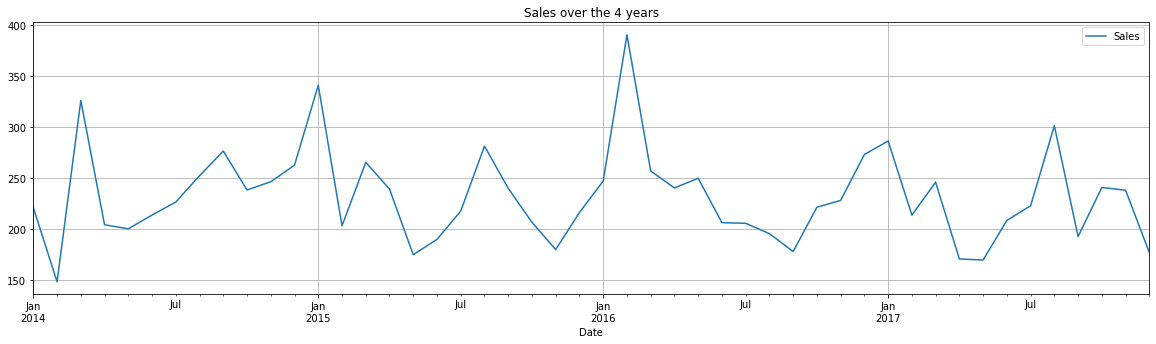

In [6]:
sales_df.plot(figsize=(20, 5))
plt.grid()
plt.legend(loc='best')
plt.title('Sales over the 4 years')
plt.show(block=False)

# Missing value Treatment

In [7]:
sales_df.isnull().sum()

Sales    0
dtype: int64

In [8]:
sales_df = sales_df.assign(Sales_Interpolation=sales_df.Sales.interpolate(method='linear'))
sales_df['Sales'] = sales_df['Sales_Interpolation']
sales_df.drop(columns=['Sales_Interpolation'],inplace=True)

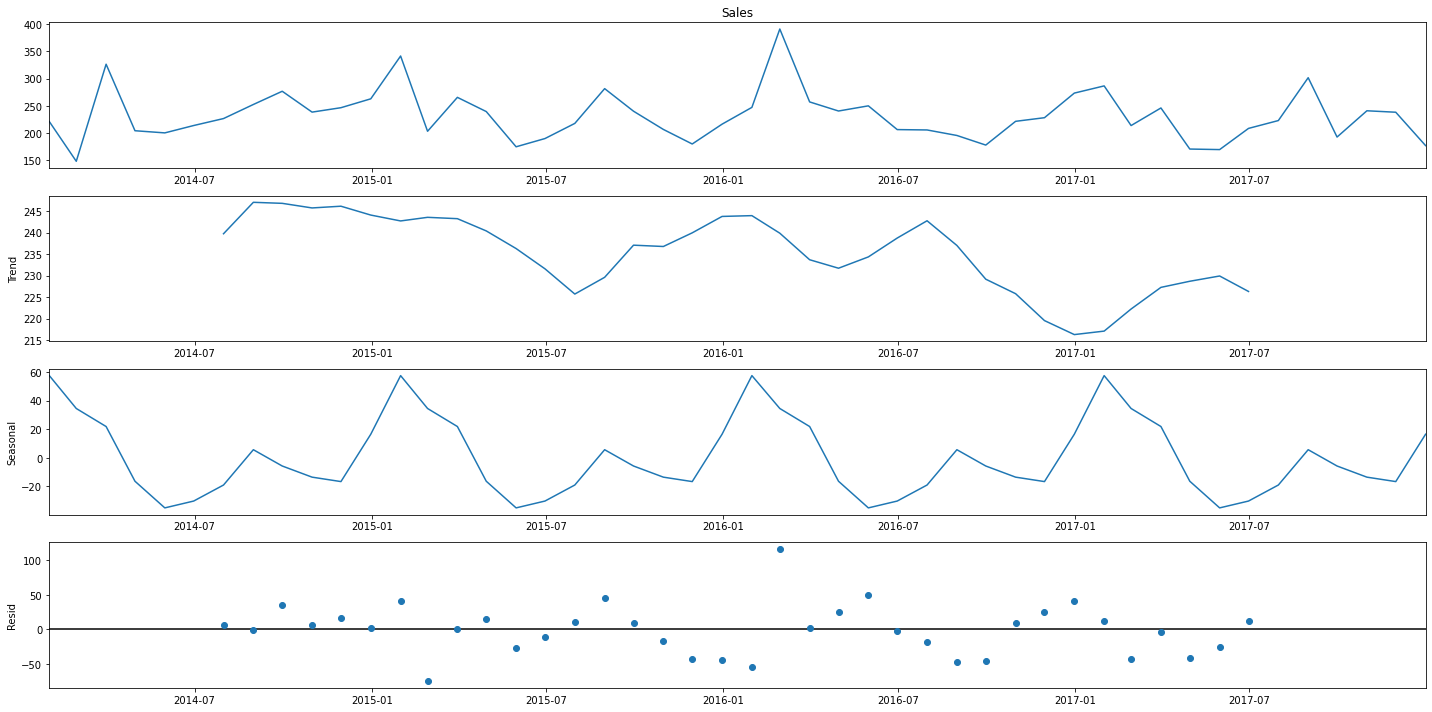

In [9]:
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 20, 10
decomposition = sm.tsa.seasonal_decompose(sales_df.Sales, period=12,model='additive')
fig = decomposition.plot()
plt.show()

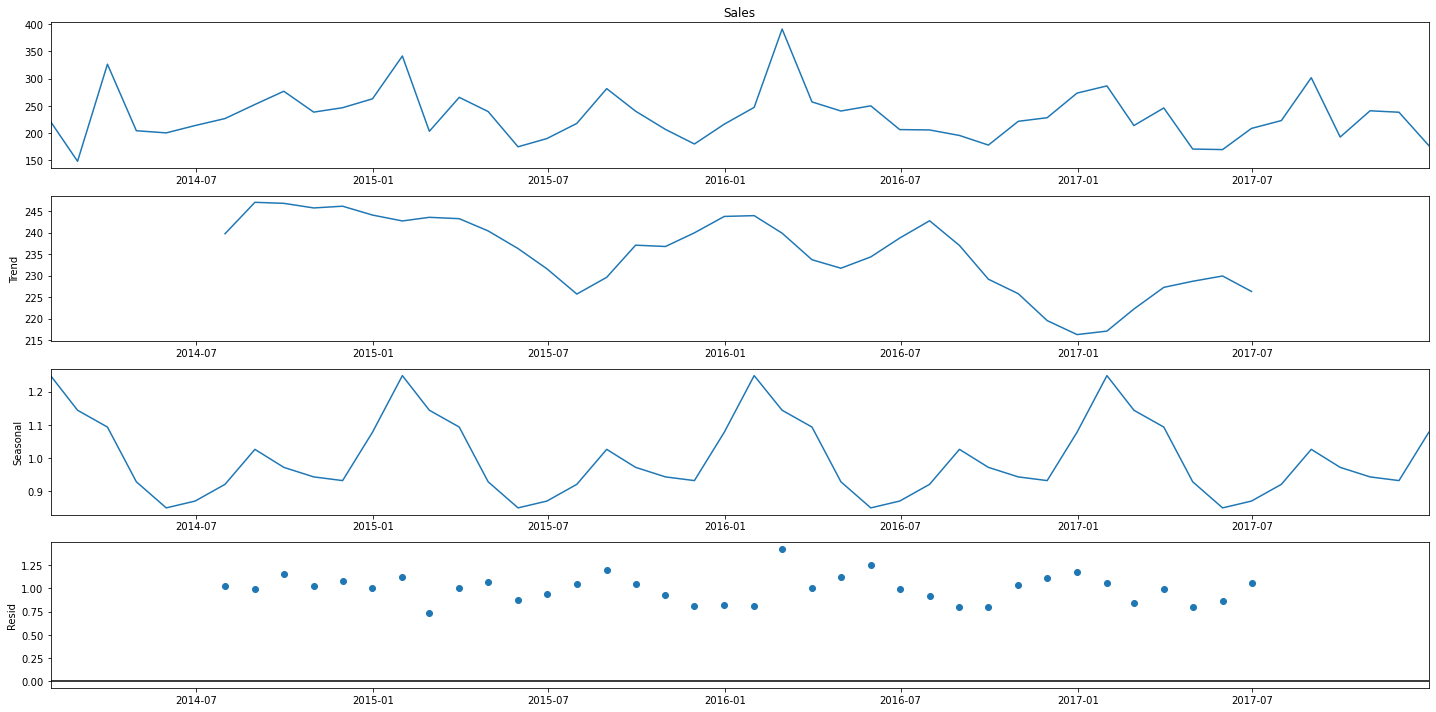

In [10]:
decomposition = sm.tsa.seasonal_decompose(sales_df.Sales, model='multiplicative') # multiplicative seasonal index
fig = decomposition.plot()
plt.show()

In [11]:
# dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]
    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [12]:
ret=checkStationarity(sales_df); ret

'p-value=1.4097136094620606e-07. Data is stationary'

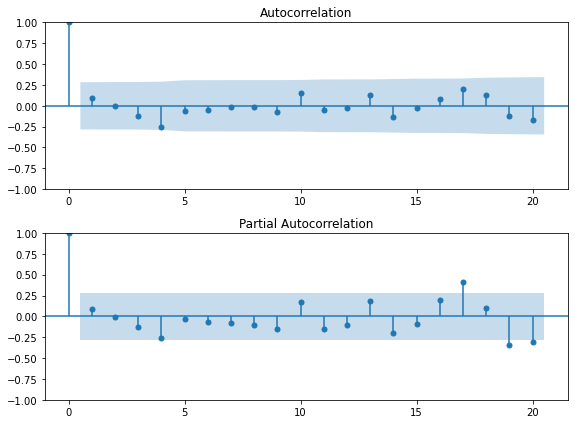

In [13]:
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sales_df, lags=20, ax=ax1)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sales_df, lags=20, ax=ax2)

plt.tight_layout()


AR (p) = 4

MA (q) = 1

In [14]:
# split the data into train and test
train = sales_df.iloc[:int(0.8 * len(sales_df))]
test = sales_df.iloc[int(0.8 * len(sales_df)):]
print("train = {}, test = {}".format(len(train), len(test)))

train = 38, test = 10


In [15]:
#with p=1
model_ar1 = ARIMA(train, order=(1,0, 0))
model_ar1_fitted = model_ar1.fit()
model_ar1_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -199.994
Date:                Mon, 26 Dec 2022   AIC                            405.988
Time:                        16:47:47   BIC                            410.901
Sample:                    01-31-2014   HQIC                           407.736
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.8948     10.432     22.612      0.000     215.448     256.341
ar.L1          0.0931      0.182      0.512      0.609      -0.263       0.450
sigma2      2181.6530    445.346      4.899      0.000    1308.791    3054.515
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.10
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             1.16
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
#with p=2
model_ar2 = ARIMA(train, order=(2,0, 0))
model_ar2_fitted = model_ar2.fit()
model_ar2_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -199.963
Date:                Mon, 26 Dec 2022   AIC                            407.925
Time:                        16:47:47   BIC                            414.475
Sample:                    01-31-2014   HQIC                           410.256
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.9433     10.044     23.491      0.000     216.258     255.629
ar.L1          0.0972      0.180      0.539      0.590      -0.256       0.450
ar.L2         -0.0425      0.275     -0.155      0.877      -0.581       0.496
sigma2      2177.9663    464.546      4.688      0.000    1267.474    3088.459
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                13.64
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             1.15
Prob(H) (two-sided):                  0.98   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
#with p=3
model_ar3 = ARIMA(train, order=(3,0,0))
model_ar3_fitted = model_ar3.fit()
model_ar3_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -199.623
Date:                Mon, 26 Dec 2022   AIC                            409.245
Time:                        16:47:47   BIC                            417.433
Sample:                    01-31-2014   HQIC                           412.158
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.8029      8.932     26.400      0.000     218.297     253.309
ar.L1          0.0937      0.181      0.519      0.604      -0.260       0.448
ar.L2         -0.0144      0.257     -0.056      0.955      -0.519       0.490
ar.L3         -0.1479      0.215     -0.689      0.491      -0.569       0.273
sigma2      2135.8504    511.133      4.179      0.000    1134.048    3137.653
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                10.07
Prob(Q):                              0.90   Prob(JB):                         0.01
Heteroskedasticity (H):               0.95   Skew:                             1.03
Prob(H) (two-sided):                  0.93   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Choosing AR model:
AIC score of AR(1) model is 405.988

AIC score of AR(2) model is 407.925

AIC score of AR(3) model is 409.245

AR(1) is the better model as it has the least AIC score

## LJung-Box test

In [18]:
pvalue = sm.stats.acorr_ljungbox(model_ar1_fitted.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


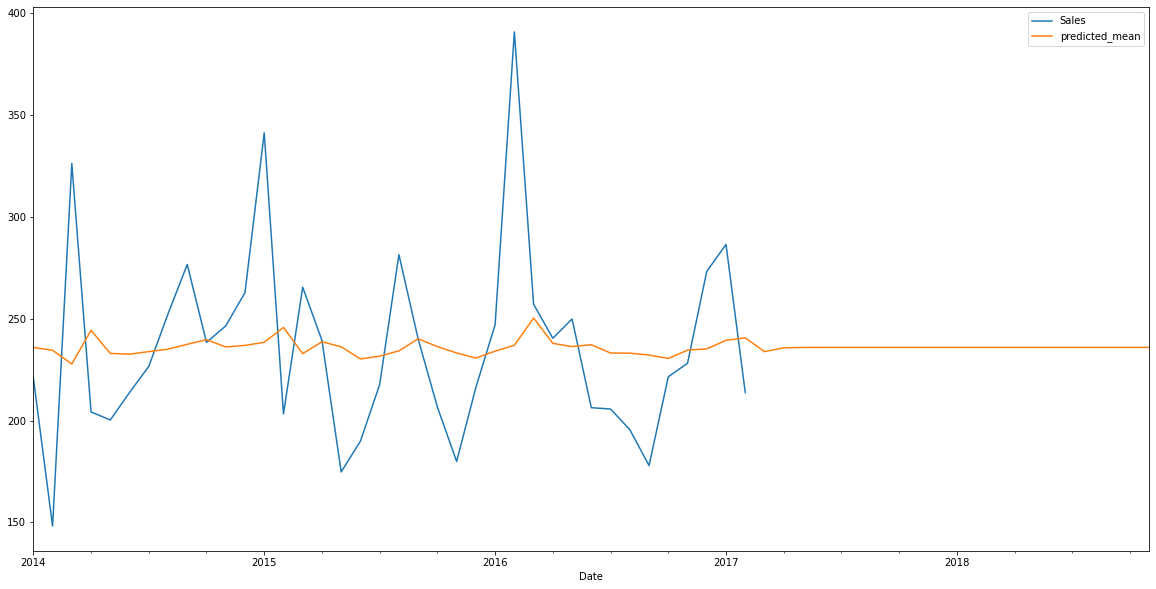

In [19]:
train.plot()
model_ar1_fitted.predict(start=0, end=58).plot();
plt.legend()

## Building MA model

In [20]:
#with q=1 
model_ma = ARIMA(train, order=(0, 0,1))
model_fitted = model_ma.fit()
model_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -199.986
Date:                Mon, 26 Dec 2022   AIC                            405.971
Time:                        16:47:48   BIC                            410.884
Sample:                    01-31-2014   HQIC                           407.719
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.8661     10.394     22.693      0.000     215.495     256.237
ma.L1          0.0969      0.181      0.534      0.593      -0.259       0.453
sigma2      2180.7467    446.980      4.879      0.000    1304.683    3056.811
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.05
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             1.16
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## LJung-Box test

In [21]:
pvalue = sm.stats.acorr_ljungbox(model_fitted.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


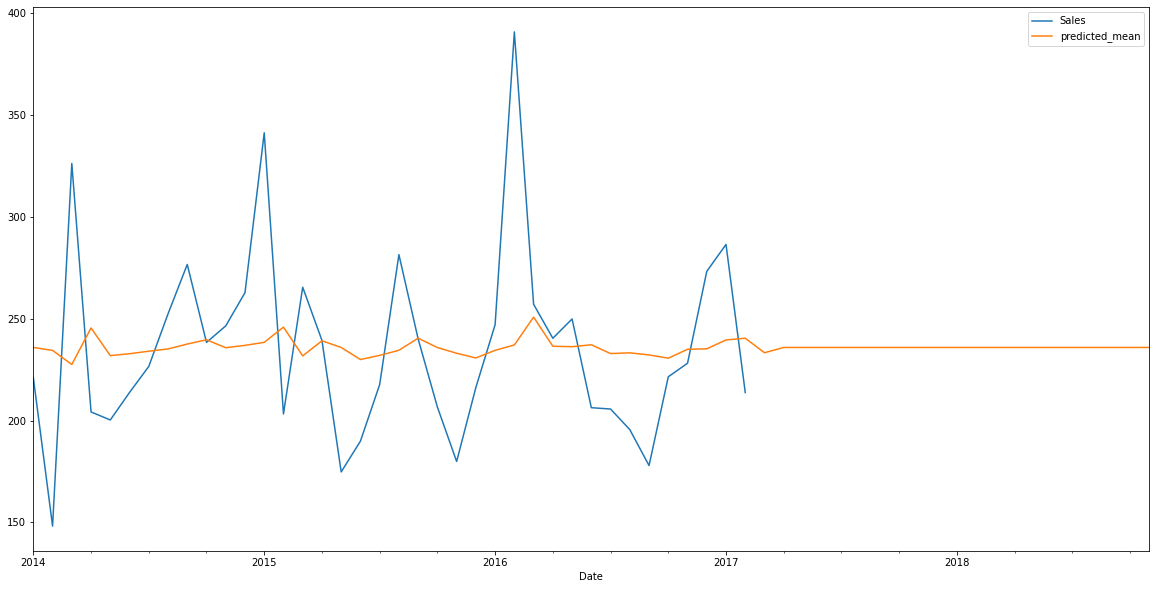

In [22]:
train.plot()
model_fitted.predict(start=0, end=58).plot();
plt.legend()

## Building ARMA model

#### With p=1 and q=1

In [23]:
p=1; q=1
m1 = ARIMA(train,order=(p,0,q)).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -199.985
Date:                Mon, 26 Dec 2022   AIC                            407.970
Time:                        16:47:49   BIC                            414.520
Sample:                    01-31-2014   HQIC                           410.300
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.9427     10.354     22.788      0.000     215.649     256.236
ar.L1         -0.0486      2.923     -0.017      0.987      -5.777       5.680
ma.L1          0.1447      2.920      0.050      0.960      -5.579       5.868
sigma2      2180.6603    450.441      4.841      0.000    1297.811    3063.509
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.03
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             1.16
Prob(H) (two-sided):                  0.97   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### With p=2 and q=1

In [24]:
p=2; q=1
m2 = ARIMA(train,order=(p,0,q)).fit()
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -197.212
Date:                Mon, 26 Dec 2022   AIC                            404.424
Time:                        16:47:49   BIC                            412.612
Sample:                    01-31-2014   HQIC                           407.337
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        237.3417      3.191     74.372      0.000     231.087     243.596
ar.L1          0.9181      0.202      4.549      0.000       0.523       1.314
ar.L2         -0.2414      0.173     -1.392      0.164      -0.581       0.098
ma.L1         -0.9999    123.993     -0.008      0.994    -244.021     242.022
sigma2      1770.5613   2.19e+05      0.008      0.994   -4.28e+05    4.32e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 9.78
Prob(Q):                              0.81   Prob(JB):                         0.01
Heteroskedasticity (H):               0.80   Skew:                             1.07
Prob(H) (two-sided):                  0.69   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### With p=3 and q=1

In [25]:
# start with initial values for p and q
p=3; q=1
m3 = ARIMA(train,order=(p,0,q)).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -196.685
Date:                Mon, 26 Dec 2022   AIC                            405.371
Time:                        16:47:49   BIC                            415.196
Sample:                    01-31-2014   HQIC                           408.866
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        237.4166      3.053     77.756      0.000     231.432     243.401
ar.L1          0.8668      0.196      4.425      0.000       0.483       1.251
ar.L2         -0.0803      0.234     -0.344      0.731      -0.538       0.378
ar.L3         -0.1743      0.235     -0.742      0.458      -0.635       0.286
ma.L1         -0.9996     46.650     -0.021      0.983     -92.432      90.433
sigma2      1705.0139   7.94e+04      0.021      0.983   -1.54e+05    1.57e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 9.70
Prob(Q):                              0.91   Prob(JB):                         0.01
Heteroskedasticity (H):               0.75   Skew:                             1.05
Prob(H) (two-sided):                  0.62   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### With p=4 and q=1

In [26]:
# start with initial values for p and q
p=4; q=1
m4 = ARIMA(train,order=(p,0,q)).fit()
m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(4, 0, 1)   Log Likelihood                -196.452
Date:                Mon, 26 Dec 2022   AIC                            406.903
Time:                        16:47:49   BIC                            418.366
Sample:                    01-31-2014   HQIC                           410.982
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        237.6265      2.873     82.714      0.000     231.996     243.257
ar.L1          0.8354      0.212      3.939      0.000       0.420       1.251
ar.L2         -0.0994      0.254     -0.391      0.696      -0.598       0.399
ar.L3         -0.0535      0.279     -0.192      0.848      -0.600       0.493
ar.L4         -0.1298      0.235     -0.552      0.581      -0.590       0.331
ma.L1         -0.9997     67.908     -0.015      0.988    -134.098     132.098
sigma2      1670.7888   1.13e+05      0.015      0.988   -2.21e+05    2.24e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.44
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             1.09
Prob(H) (two-sided):                  0.60   Kurtosis:                         4.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Selection of ARMA model:
AIC score of ARMA(1,1) model is 407.970

AIC score of ARMA(2,1) model is 409.978

AIC score of ARMA(3,1) model is 405.371

AIC score of ARMA(4,1) model is 406.903

Hence ARMA(3, 1) is the better model as it has the least AIC score

In [27]:
predictions = m3.predict(0,len(test)-1)
print(predictions)

Date
2014-01-31    237.416615
2014-02-28    236.211044
2014-03-31    231.199135
2014-04-30    248.611226
2014-05-31    253.987320
2014-06-30    238.393372
2014-07-31    247.214596
2014-08-31    254.725569
2014-09-30    257.491089
2014-10-31    254.711276
Freq: M, Name: predicted_mean, dtype: float64


## Printing Actual, Predicted and Error values

In [28]:
test_s = test.squeeze()
actual = []; pred = []

for i in range(len(predictions)):
    actual.append(test_s[i])
    pred.append(predictions[i])

df_res = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)

       actual   predicted        err
0  245.967381  237.416615   8.550766
1  170.620094  236.211044 -65.590950
2  169.636707  231.199135 -61.562428
3  208.481771  248.611226 -40.129455
4  222.877408  253.987320 -31.109913
5  301.495235  238.393372  63.101863
6  192.635345  247.214596 -54.579250
7  240.813096  254.725569 -13.912473
8  238.149973  257.491089 -19.341116
9  176.922968  254.711276 -77.788308


# Visualizing Error Plot

<AxesSubplot:>

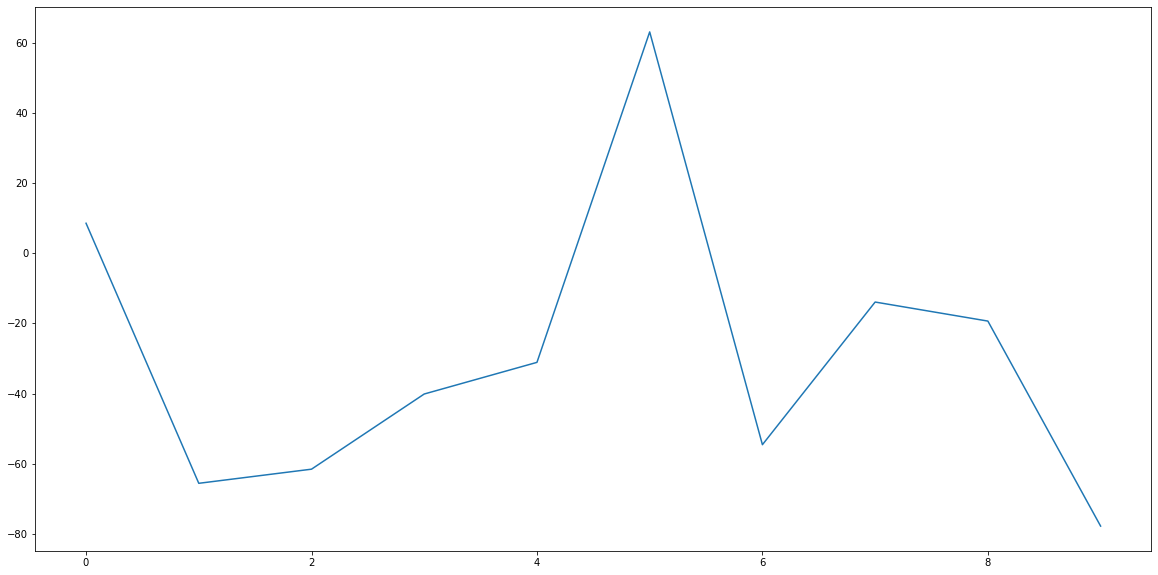

In [29]:
df_res.err.plot()

## LJung-Box test

In [30]:
pvalue = sm.stats.acorr_ljungbox(m3.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [31]:
# MSE
msg = 'ARMA Model. Order=(' + str(p) + ',' + str(q) + ')'
mse1 = mean_squared_error(df_res.actual, df_res.predicted)
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(4,1)
	MSE = 2432.2816902963814
	RMSE = 49.318167953568405


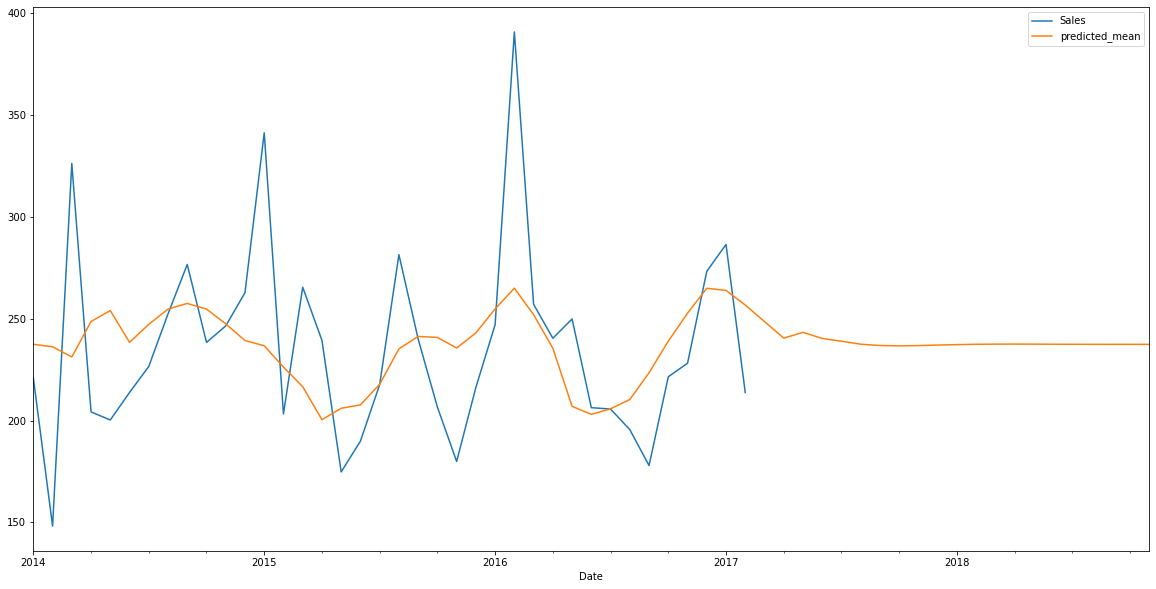

In [32]:
train.plot()
m3.predict(start=0, end=58).plot();
plt.legend()